In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
print (tf.__version__)

2.3.1


In [3]:
#load and prepare data. We are using MNIST data and we will pre-process it first
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 1s 0us/step


In [4]:
#simple encoder network
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [5]:
# sample new similar points from the latent space
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [6]:
# map the latent space points to the reconstructed
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [7]:
# Compile the model
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [8]:
# train the VAE model
vae.fit(x_train, epochs=20, batch_size=32,validation_data=(x_test, None))

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 188.0416 - val_loss: 167.2570
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 164.8862 - val_loss: 163.0601
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 161.8939 - val_loss: 161.0603
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 159.8943 - val_loss: 159.3362
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 158.2919 - val_loss: 157.9060
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 157.0417 - val_loss: 156.9501
Epoch 7/20
1875/1875 [==============================] - 5s 2ms/step - loss: 156.0370 - val_loss: 155.9004
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 155.2181 - val_loss: 155.3601
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 154.5484 - val_loss: 154.7074
Epoch 10/20
1875/1875 [=======================

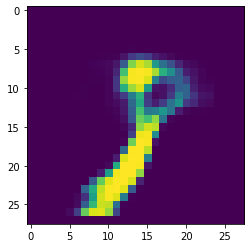

In [16]:
# generate new digit
n = 2
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n-1)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi/2, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        plt.imshow(digit)